In [1]:
import importlib
import PlumeModel
from PlumeModel import preprocess_ARMBE, preprocess_data
importlib.reload(PlumeModel)
import time
import matplotlib.pyplot as plt
from pathlib import Path


In [2]:
output_dir = '/home/fiaz/plume_model/'  # directory to save the output files
output_file_name = 'plume_props_CACTI'  # name of the output file
input_dir = '/neelin2020/ARM/CACTI/'
fils = [str(i) for i in Path(input_dir).glob('corarmbeatm*.nc')]  # look for all .nc files in the directory

pm = PlumeModel.PlumeModel(fils = fils,
                           preprocess = preprocess_ARMBE,
                           output_file_name = output_file_name, 
                           output_dir=output_dir, 
                           launch_opt = 'specified',
                           launch_level = 825)

In [3]:
pm.preprocess_data()
pm.mixing_coefficients()

In [4]:
stime = time.time()
pm.run_plume(mix = pm.mix_opt)
print(f'Done. Took {time.time()-stime: .3f} seconds')

RUNNING DIB PLUME COMPUTATION
Done. Took  1.845 seconds


In [5]:
pm.postprocess_save()

SAVING FILE
File saved as /home/fiaz/plume_model/plume_props_CACTI.nc


/home/fiaz/plume_model/thermodynamic_functions.py:268: RuntimeWarning: invalid value encountered in log
  TL = (2840. / ((3.5*np.log(temp)) - (np.log(ev_hPa)) - 4.805)) + 55.
/home/fiaz/plume_model/thermodynamic_functions.py:268: RuntimeWarning: divide by zero encountered in log
  TL = (2840. / ((3.5*np.log(temp)) - (np.log(ev_hPa)) - 4.805)) + 55.


### Analyze saved output

In [6]:
import xarray as xr
# compute LFT buoy

def compute_layer_ave_buoy(ds, pstrt = 800, pend = 500):
    """
    Use the virtual temperature to compute 
    layer-averaged buoyancy
    """
    g = 9.8
    buoy = g * (ds.Tv_plume - ds.Tv_env)/ds.Tv_env
    buoy_slice = buoy.sel(lev = slice(pstrt, pend)).dropna('lev')
    layer_depth = buoy_slice.lev.isel(lev = 0) - buoy_slice.lev.isel(lev = -1) 
    return -buoy_slice.integrate('lev')/(layer_depth)
 

fil_out = pm.output_file_name.with_suffix('.nc')
ds = xr.open_dataset(fil_out)
buoy_lft = compute_layer_ave_buoy(ds)
ds_cacti = xr.open_mfdataset(fils)
ds_cacti = ds_cacti.where(ds_cacti.time.isin(buoy_lft.time), drop = True)
prc = ds_cacti.precip_rate_sfc
prc = prc.where(prc.time.isin(buoy_lft.time), drop = True)


Hydrometeor information

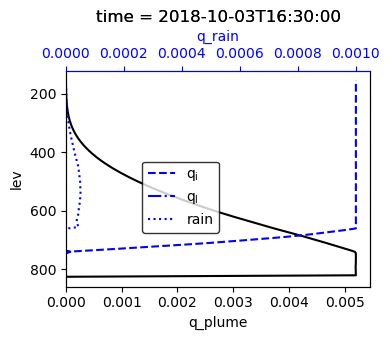

In [7]:
g = 9.8 
fig, axx = plt.subplots(1, 1, figsize = (4, 3.5))
tidx = 10

ax = axx
ax2 = ax.twiny()
ds.q_plume.isel(time = tidx).plot(y = 'lev', yincrease = False, ax = ax, color = 'black')
ds.qi_plume.isel(time = tidx).plot(y = 'lev', yincrease = False, ax = ax2, c = 'blue', linestyle = '--', label = '$\mathrm{q_i}$')
ds.ql_plume.isel(time = tidx).plot(y = 'lev', yincrease = False, ax = ax2, c = 'blue', linestyle = '-.', label = '$\mathrm{q_l}$')
ds.q_rain.isel(time = tidx).plot(y = 'lev', yincrease = False, ax = ax2, c = 'blue', linestyle = ':', label = 'rain')

ax2.spines['top'].set_color('blue') 
ax2.xaxis.label.set_color('blue')
ax2.tick_params(axis='x', colors='blue')
ax.set_xlim(left = 0)
ax2.set_xlim(left = 0)
leg = ax2.legend(loc = (0.25, 0.25))
leg.get_frame().set_edgecolor('black')

# ax = axx[1]
# ds.qi_plume.isel(time = tidx).plot(y = 'lev', yincrease = False, ax = ax, c = 'blue', linestyle = '--', label = '$\mathrm{q_i}$')
# ds.ql_plume.isel(time = tidx).plot(y = 'lev', yincrease = False, ax = ax, c = 'blue', linestyle = '-.', label = '$\mathrm{q_l}$')
# ds.q_rain.isel(time = tidx).plot(y = 'lev', yincrease = False, ax = ax, c = 'blue', linestyle = ':', label = 'rain')


plt.tight_layout()

Thermal or Archimedean Buoyancy: $ B = g \frac{T_{vp} - \bar{T}_v}{\bar{T}_v}$<br>
$B_L = \frac{1}{\Delta p_L}\int^{500}_{800} B dp$<br>
$T_v = T(1 + \epsilon q_v - q_c)$ <br>
$\theta_e = f(T,q,p)$

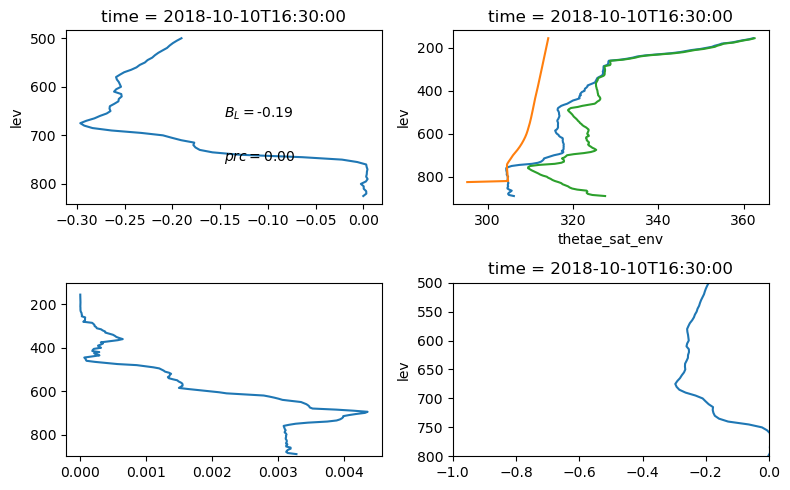

In [8]:
g = 9.8 
fig, axx = plt.subplots(2, 2, figsize = (8,5))
tidx = 40

ax = axx[0,0]
buoy = g * (ds.Tv_plume - ds.Tv_env)/ds.Tv_env
buoy_slice = buoy.sel(lev = slice(900, 500)).dropna('lev')
buoy_slice.isel(time = tidx).plot(y = 'lev', yincrease = False, ax = ax)
ax.text(0.5, 0.5, f'$B_L=${buoy_lft.isel(time = tidx).item():.2f}', transform = ax.transAxes)
ax.text(0.5, 0.25, f'$prc=${ds_cacti.precip_rate_sfc.isel(time = tidx).values.item():.2f}', transform = ax.transAxes)

ax = axx[0, 1]
ds.thetae_env.isel(time = tidx).plot(y = 'lev', yincrease = False, ax = ax)
ds.thetae_plume.isel(time = tidx).plot(y = 'lev', yincrease = False, ax = ax)

ds.thetae_sat_env.isel(time = tidx).plot(y = 'lev', yincrease = False, ax = ax)

ax = axx[1,0]
ax.plot(pm.q[tidx, :], pm.lev)
ax.set_ylim(900, 100)
# pm.q(time = tidx).plot(y = 'lev', yincrease = False, ax = ax)

ax = axx[1,1]
# ds_cacti.sphum_p.isel(time = tidx).plot(y = 'pressure', ax = ax, yincrease = False)
(9.8 * (ds.Tv_plume - ds.Tv_env)/ds.Tv_env).isel(time = tidx).plot(y = 'lev', ax = ax, yincrease = False)
ax.set_ylim(800, 500)
ax.set_xlim(-1, 0)
plt.tight_layout()

In [20]:
# manual integration to check xarray's functionality
# x = buoy_slice.sel(lev = slice(800, 500))
# y = (x.isel(lev = slice (1, None)).assign_coords(lev = range(x.lev.size - 1)) + x.isel(lev = slice (0, -1)).assign_coords(lev = range(x.lev.size - 1))) * 0.5
# dp = abs(buoy_slice.sel(lev = slice(800, 500)).lev.diff('lev')).assign_coords(lev = range(x.lev.size - 1))
# Deltap = x.lev.isel(lev = 0) - x.lev.isel(lev = -1)
# buoy_lft_direct = (y * dp).sum('lev')/Deltap

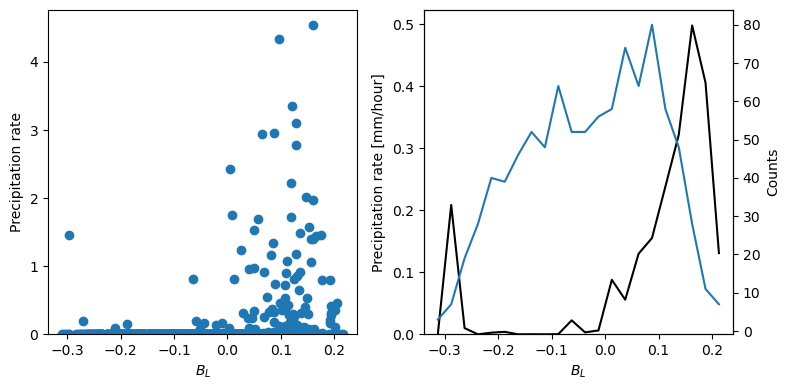

In [13]:
import numpy as np
buoy_bins = np.arange(-0.5, 0.25, 0.025)

fig, axx = plt.subplots(1, 2, figsize = (8, 4))
ax = axx[0]
ax.scatter(buoy_lft, ds_cacti.precip_rate_sfc)
ax.set_ylim(bottom = 0)
ax.set_ylabel('Precipitation rate')
ax.set_xlabel('$B_L$')

ax = axx[1]
ax2 = ax.twinx()
ds_cacti.precip_rate_sfc.groupby_bins(buoy_lft, bins = buoy_bins).count().plot(ax = ax2)
ds_cacti.precip_rate_sfc.groupby_bins(buoy_lft, bins = buoy_bins).mean().plot(ax = ax, c = 'black')
ax.set_ylim(bottom = 0)
ax2.set_ylabel('Counts')
ax.set_xlabel('$B_L$')
plt.tight_layout()


/tmp/ipykernel_128543/1662975625.py:31: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cb = plt.colorbar(ScalarMappable(cmap = cm, norm = norm),


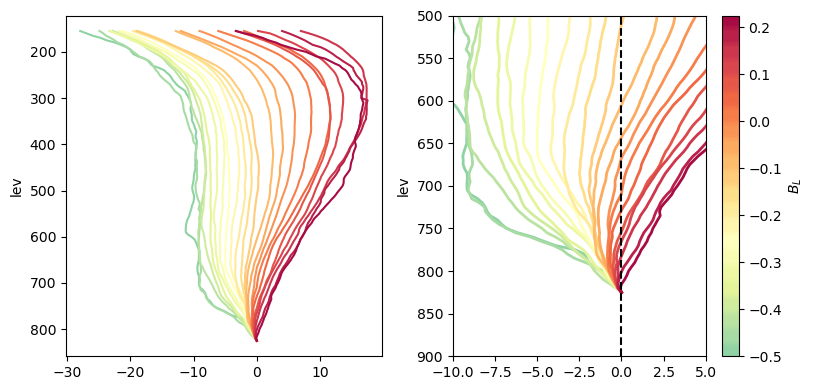

In [14]:
from matplotlib.colors import Normalize
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.cm import ScalarMappable
from matplotlib import ticker

fig, axx = plt.subplots(1, 2, figsize = (8, 4))

ax = axx[0]
DeltaTv = (ds.Tv_plume - ds.Tv_env).groupby_bins(buoy_lft, bins = buoy_bins)
cmap = plt.colormaps['Spectral_r']
norm = Normalize(vmin = buoy_bins[0], vmax = buoy_bins[-1])
cm_list = []
for i, (key, group) in enumerate(DeltaTv):
    group.mean('time').plot(y = 'lev', yincrease = False, 
                            ax = ax, label = key, color = cmap(norm(key.mid)))
    
    group.mean('time').plot(y = 'lev', yincrease = False, 
                            ax = axx[1], label = key, linewidth = 2.,
                            color = cmap(norm(key.mid)))
    cm_list.append(cmap(norm(key.mid)))
    
    cm_list.append(cmap(norm(key.mid)))

cm = LinearSegmentedColormap.from_list('defcol', cm_list)

axx[1].set_ylim(900,500)
axx[1].set_xlim(-10, 5)
axx[1].vlines(0, 900, 500, linestyle = '--', color = 'black')
plt.tight_layout()

cb = plt.colorbar(ScalarMappable(cmap = cm, norm = norm), 
             ticks = buoy_bins[::4], label='$B_L$')
cb.ax.yaxis.set_major_locator(ticker.AutoLocator())


Plot hydrometeor information

Some times have freezing level below the LCL, which permits no plume liquid water to exist